## Dependencies

In [1]:
import random, os, warnings, math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

### Hardware configuration

In [2]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Load data

In [3]:
train_filepath = '/kaggle/input/commonlitreadabilityprize/train.csv'
train = pd.read_csv(train_filepath)
print(f'Train samples: {len(train)}')
display(train.head())
# removing unused columns
train.drop(['url_legal', 'license'], axis=1, inplace=True)

Train samples: 2834


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca...",-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the ch...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, p...",-1.054013,0.450007
4,37c1b32fb,NaN,NaN,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one w...",0.247197,0.510845


# Model parameters

In [4]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS
EPOCHS = 35
ES_PATIENCE = 10
PATIENCE = 2
N_FOLDS = 5
SEQ_LEN = 300
BASE_MODEL = '/kaggle/input/huggingface-roberta/roberta-base/'

## Auxiliary functions

In [5]:
# Datasets utility functions
def custom_standardization(text):
    text = text.lower() # if encoder is uncased
    text = text.strip()
    return text


def sample_target(features, target):
    mean, stddev = target
    sampled_target = tf.random.normal([], mean=tf.cast(mean, dtype=tf.float32), 
                                      stddev=tf.cast(stddev, dtype=tf.float32), dtype=tf.float32)
    
    return (features, sampled_target)
    

def get_dataset(pandas_df, tokenizer, labeled=True, ordered=False, repeated=False, 
                is_sampled=False, batch_size=32, seq_len=128):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    text = [custom_standardization(text) for text in pandas_df['excerpt']]
    
    # Tokenize inputs
    tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
    
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']}, 
                                                      (pandas_df['target'], pandas_df['standard_error'])))
        if is_sampled:
            dataset = dataset.map(sample_target, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']})
        
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


def plot_metrics(history):
    metric_list = list(history.keys())
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    axes = axes.flatten()
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# Model

In [6]:
def model_fn(encoder, seq_len=256):
    input_ids = L.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
    input_attention_mask = L.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    outputs = encoder({'input_ids': input_ids, 
                       'attention_mask': input_attention_mask})
    last_hidden_state = outputs['last_hidden_state']
    
    x = L.GlobalAveragePooling1D()(last_hidden_state)
#     x = L.Dropout(.5)(x)
    output = L.Dense(1, name='output')(x)
    
    model = Model(inputs=[input_ids, input_attention_mask], outputs=output)

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.MeanSquaredError(), 
                  metrics=[metrics.RootMeanSquaredError()])
    
    return model


with strategy.scope():
#     encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
    encoder = TFAutoModel.from_pretrained(BASE_MODEL)
    model = model_fn(encoder, SEQ_LEN)
    
model.summary()

Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_roberta_model[0][0]       

# Training

In [7]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(train)):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')

    # Model
    K.clear_session()
    with strategy.scope():
#         encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
        encoder = TFAutoModel.from_pretrained(BASE_MODEL)
        model = model_fn(encoder, SEQ_LEN)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_root_mean_squared_error', mode='min', 
                                 save_best_only=True, save_weights_only=True)

    # Train
    history = model.fit(x=get_dataset(train.loc[idxT], tokenizer, repeated=True, is_sampled=True, 
                                      batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        validation_data=get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                                                    batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        steps_per_epoch=50, 
                        callbacks=[es, checkpoint], 
                        epochs=EPOCHS,  
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.load_weights(model_path)
    
    # Results
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_root_mean_squared_error']):.4f}")

    # OOF predictions
    valid_ds = get_dataset(train.loc[idxV], tokenizer, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    oof_labels.append([target[0].numpy() for sample, target in iter(valid_ds.unbatch())])
    x_oof = valid_ds.map(lambda sample, target: sample)
    oof_pred.append(model.predict(x_oof))


FOLD: 1
TRAIN: 2267 VALID: 567


Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/35
50/50 - 93s - loss: 0.9684 - root_mean_squared_error: 0.9840 - val_loss: 0.4412 - val_root_mean_squared_error: 0.6642
Epoch 2/35
50/50 - 7s - loss: 0.5472 - root_mean_squared_error: 0.7397 - val_loss: 0.3787 - val_root_mean_squared_error: 0.6154
Epoch 3/35
50/50 - 6s - loss: 0.4477 - root_mean_squared_error: 0.6691 - val_loss: 0.3106 - val_root_mean_squared_error: 0.5573
Epoch 4/35
50/50 - 6s - loss: 0.3985 - root_mean_squared_error: 0.6312 - val_loss: 0.3374 - val_root_mean_squared_error: 0.5809
Epoch 5/35
50/50 - 6s - loss: 0.3640 - root_mean_squared_error: 0.6033 - val_loss: 0.4941 - val_root_mean_squared_error: 0.7029
Epoch 6/35
50/50 - 6s - loss: 0.3607 - root_mean_squared_error: 0.6006 - val_loss: 0.4560 - val_root_mean_squared_error: 0.6752
Epoch 7/35
50/50 - 6s - loss: 0.3505 - root_mean_squared_error: 0.5920 - val_loss: 0.3874 - val_root_mean_squared_error: 0.6224
Epoch 8/35
50/50 - 6s - loss: 0.3430 - root_mean_squared_error: 0.5856 - val_loss: 0.4018 - val_root_me

Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/35
50/50 - 102s - loss: 1.1089 - root_mean_squared_error: 1.0530 - val_loss: 0.4586 - val_root_mean_squared_error: 0.6772
Epoch 2/35
50/50 - 6s - loss: 0.6012 - root_mean_squared_error: 0.7754 - val_loss: 0.4952 - val_root_mean_squared_error: 0.7037
Epoch 3/35
50/50 - 6s - loss: 0.5239 - root_mean_squared_error: 0.7238 - val_loss: 0.3877 - val_root_mean_squared_error: 0.6227
Epoch 4/35
50/50 - 6s - loss: 0.4811 - root_mean_squared_error: 0.6936 - val_loss: 0.3163 - val_root_mean_squared_error: 0.5624
Epoch 5/35
50/50 - 6s - loss: 0.4696 - root_mean_squared_error: 0.6853 - val_loss: 0.3916 - val_root_mean_squared_error: 0.6258
Epoch 6/35
50/50 - 6s - loss: 0.4256 - root_mean_squared_error: 0.6524 - val_loss: 0.3595 - val_root_mean_squared_error: 0.5996
Epoch 7/35
50/50 - 6s - loss: 0.4008 - root_mean_squared_error: 0.6331 - val_loss: 0.3693 - val_root_mean_squared_error: 0.6077
Epoch 8/35
50/50 - 6s - loss: 0.3559 - root_mean_squared_error: 0.5966 - val_loss: 0.4957 - val_root_m

Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/35
50/50 - 96s - loss: 0.9954 - root_mean_squared_error: 0.9977 - val_loss: 0.3913 - val_root_mean_squared_error: 0.6255
Epoch 2/35
50/50 - 6s - loss: 0.5724 - root_mean_squared_error: 0.7566 - val_loss: 0.4849 - val_root_mean_squared_error: 0.6964
Epoch 3/35
50/50 - 6s - loss: 0.4606 - root_mean_squared_error: 0.6787 - val_loss: 0.5131 - val_root_mean_squared_error: 0.7163
Epoch 4/35
50/50 - 6s - loss: 0.3872 - root_mean_squared_error: 0.6223 - val_loss: 0.4013 - val_root_mean_squared_error: 0.6335
Epoch 5/35
50/50 - 6s - loss: 0.3594 - root_mean_squared_error: 0.5995 - val_loss: 0.3831 - val_root_mean_squared_error: 0.6190
Epoch 6/35
50/50 - 6s - loss: 0.3438 - root_mean_squared_error: 0.5864 - val_loss: 0.3392 - val_root_mean_squared_error: 0.5824
Epoch 7/35
50/50 - 6s - loss: 0.3462 - root_mean_squared_error: 0.5884 - val_loss: 0.3310 - val_root_mean_squared_error: 0.5753
Epoch 8/35
50/50 - 6s - loss: 0.3289 - root_mean_squared_error: 0.5735 - val_loss: 0.3786 - val_root_me

Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/35
50/50 - 96s - loss: 0.8367 - root_mean_squared_error: 0.9147 - val_loss: 0.3603 - val_root_mean_squared_error: 0.6002
Epoch 2/35
50/50 - 6s - loss: 0.5380 - root_mean_squared_error: 0.7335 - val_loss: 0.3866 - val_root_mean_squared_error: 0.6218
Epoch 3/35
50/50 - 6s - loss: 0.4692 - root_mean_squared_error: 0.6850 - val_loss: 0.5736 - val_root_mean_squared_error: 0.7573
Epoch 4/35
50/50 - 6s - loss: 0.3724 - root_mean_squared_error: 0.6103 - val_loss: 0.4995 - val_root_mean_squared_error: 0.7068
Epoch 5/35
50/50 - 6s - loss: 0.3623 - root_mean_squared_error: 0.6019 - val_loss: 0.3138 - val_root_mean_squared_error: 0.5601
Epoch 6/35
50/50 - 6s - loss: 0.3715 - root_mean_squared_error: 0.6095 - val_loss: 0.4255 - val_root_mean_squared_error: 0.6523
Epoch 7/35
50/50 - 6s - loss: 0.3525 - root_mean_squared_error: 0.5937 - val_loss: 0.3388 - val_root_mean_squared_error: 0.5821
Epoch 8/35
50/50 - 6s - loss: 0.3658 - root_mean_squared_error: 0.6048 - val_loss: 0.5482 - val_root_me

Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/35
50/50 - 98s - loss: 1.0933 - root_mean_squared_error: 1.0456 - val_loss: 0.6014 - val_root_mean_squared_error: 0.7755
Epoch 2/35
50/50 - 6s - loss: 0.5682 - root_mean_squared_error: 0.7538 - val_loss: 0.3092 - val_root_mean_squared_error: 0.5560
Epoch 3/35
50/50 - 6s - loss: 0.4788 - root_mean_squared_error: 0.6920 - val_loss: 0.3542 - val_root_mean_squared_error: 0.5952
Epoch 4/35
50/50 - 6s - loss: 0.3880 - root_mean_squared_error: 0.6229 - val_loss: 0.4835 - val_root_mean_squared_error: 0.6953
Epoch 5/35
50/50 - 6s - loss: 0.3634 - root_mean_squared_error: 0.6028 - val_loss: 0.2847 - val_root_mean_squared_error: 0.5335
Epoch 6/35
50/50 - 6s - loss: 0.3367 - root_mean_squared_error: 0.5803 - val_loss: 0.3194 - val_root_mean_squared_error: 0.5652
Epoch 7/35
50/50 - 6s - loss: 0.3418 - root_mean_squared_error: 0.5847 - val_loss: 0.3159 - val_root_mean_squared_error: 0.5620
Epoch 8/35
50/50 - 7s - loss: 0.3449 - root_mean_squared_error: 0.5873 - val_loss: 0.5637 - val_root_me

## Model loss and metrics graph


FOLD: 1


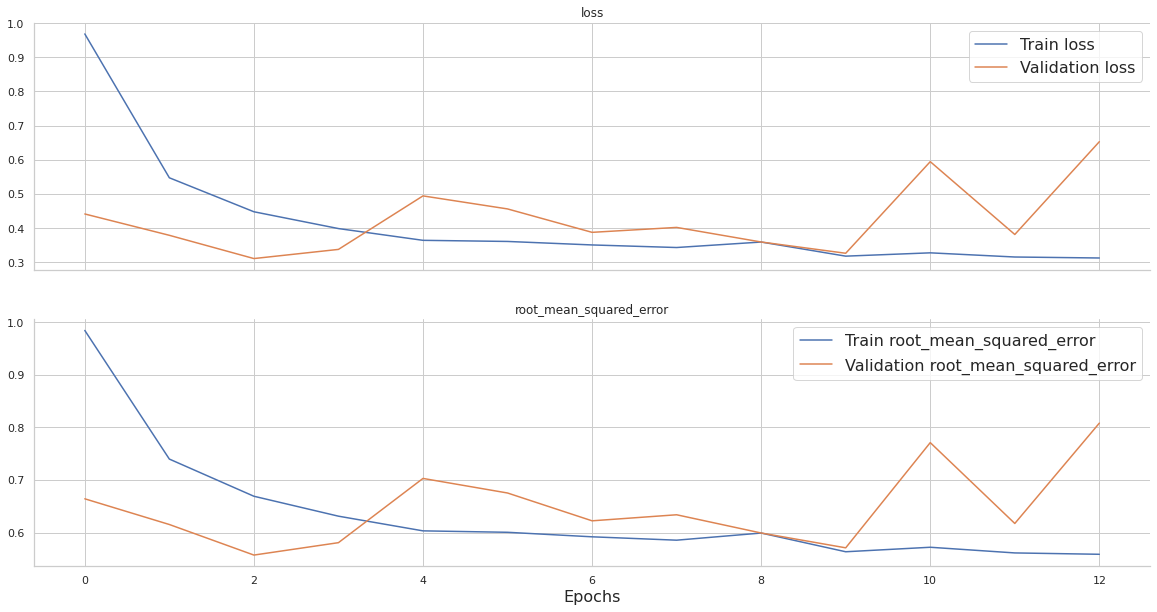


FOLD: 2


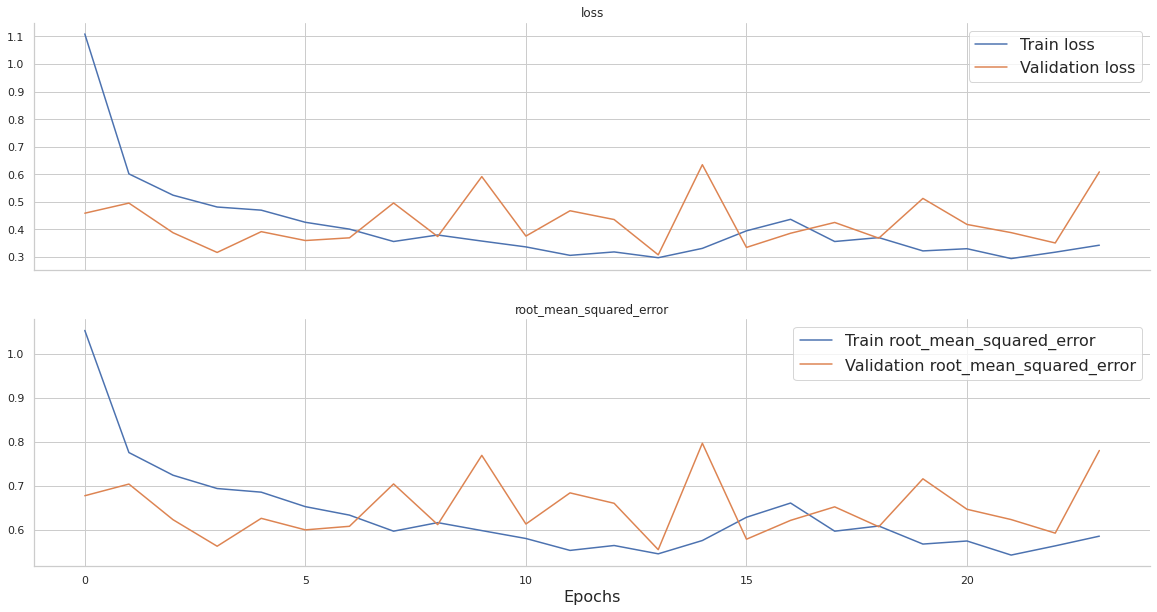


FOLD: 3


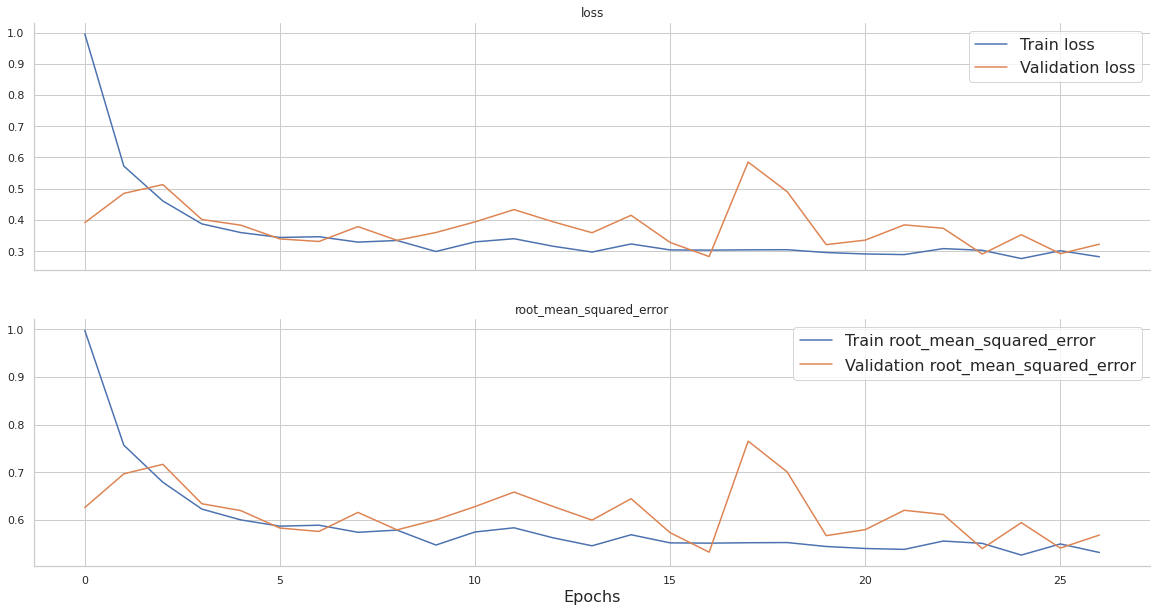


FOLD: 4


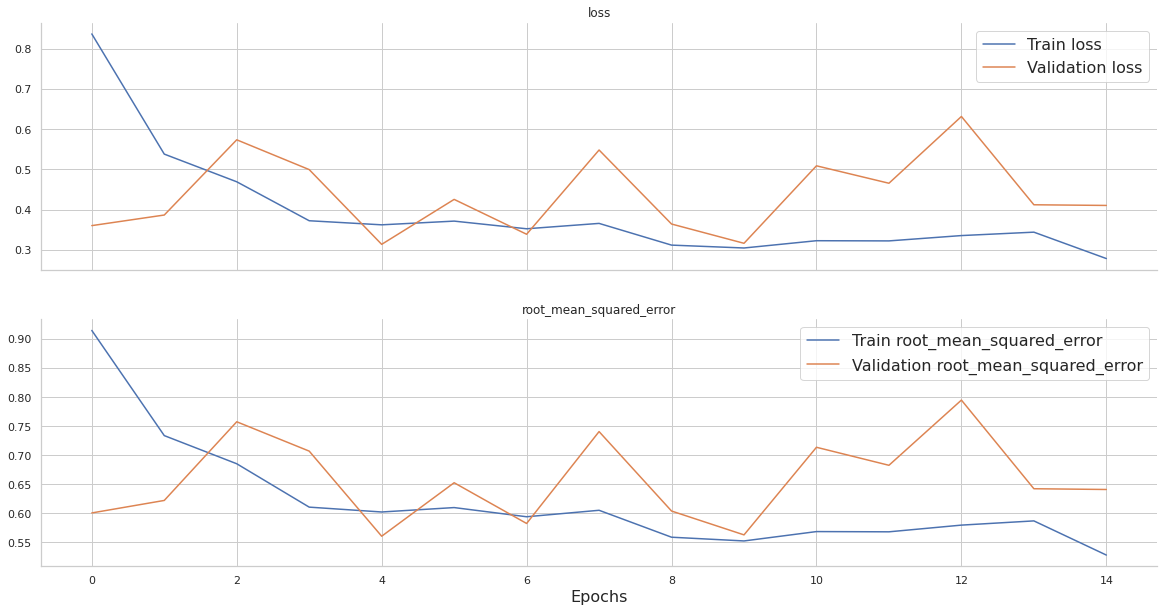


FOLD: 5


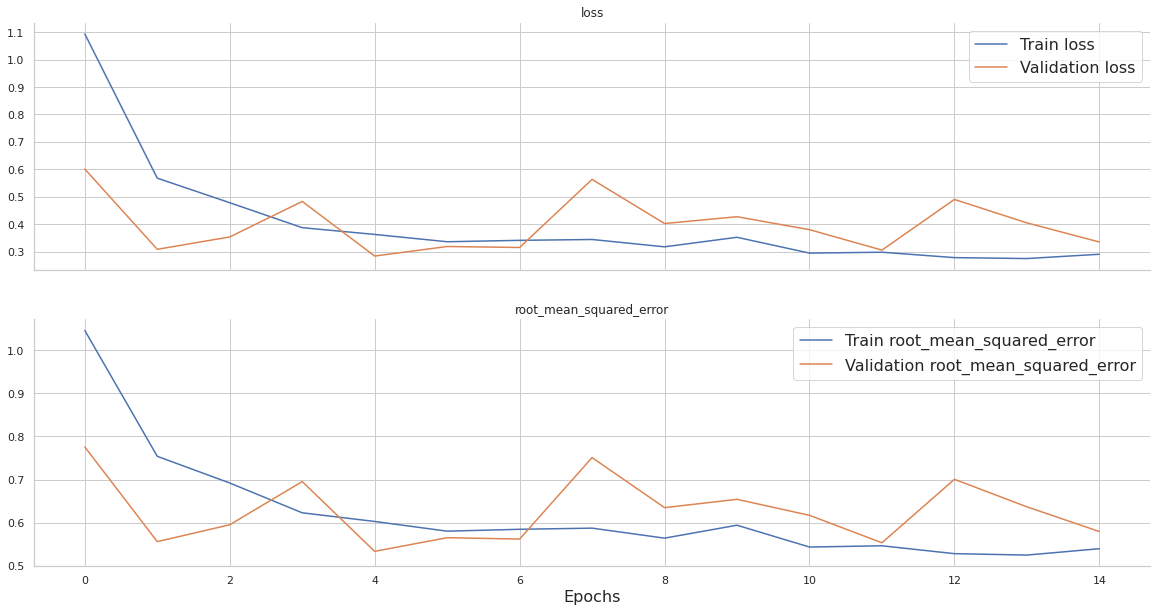

In [8]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

We are evaluating the model on the `OOF` predictions, it stands for `Out Of Fold`, since we are training using `K-Fold` our model will see all the data, and the correct way to evaluate each fold is by looking at the predictions that are not from that fold.

## OOF metrics

In [9]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)


for fold, history in enumerate(history_list):
    print(f"FOLD {fold+1} RMSE: {np.min(history['val_root_mean_squared_error']):.4f}")
    
print(f'OOF RMSE: {mean_squared_error(y_true, y_preds, squared=False):.4f}')

FOLD 1 RMSE: 0.5573
FOLD 2 RMSE: 0.5546
FOLD 3 RMSE: 0.5317
FOLD 4 RMSE: 0.5601
FOLD 5 RMSE: 0.5335
OOF RMSE: 0.5476


### **Error analysis**, label x prediction distribution

Here we can compare the distribution from the labels and the predicted values, in a perfect scenario they should align.

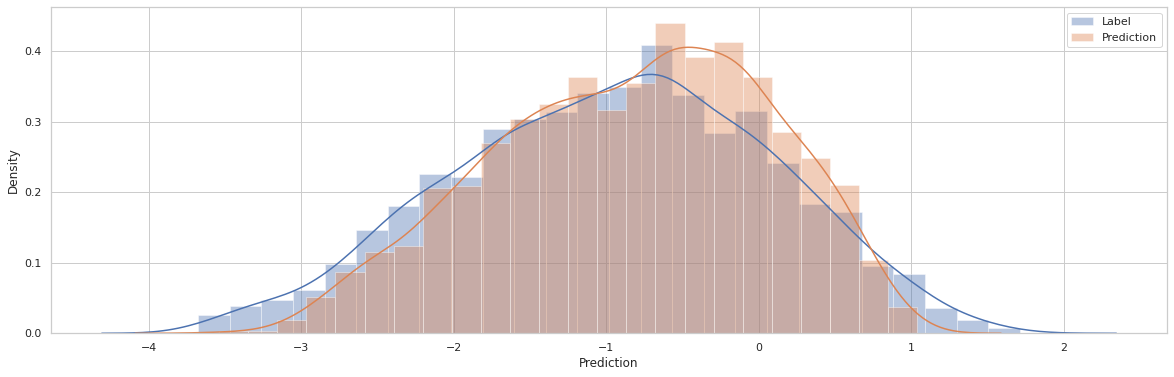

In [10]:
preds_df = pd.DataFrame({'Label': y_true, 'Prediction': y_preds[:,0]})

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(preds_df['Label'], ax=ax, label='Label')
sns.distplot(preds_df['Prediction'], ax=ax, label='Prediction')
ax.legend()
plt.show()

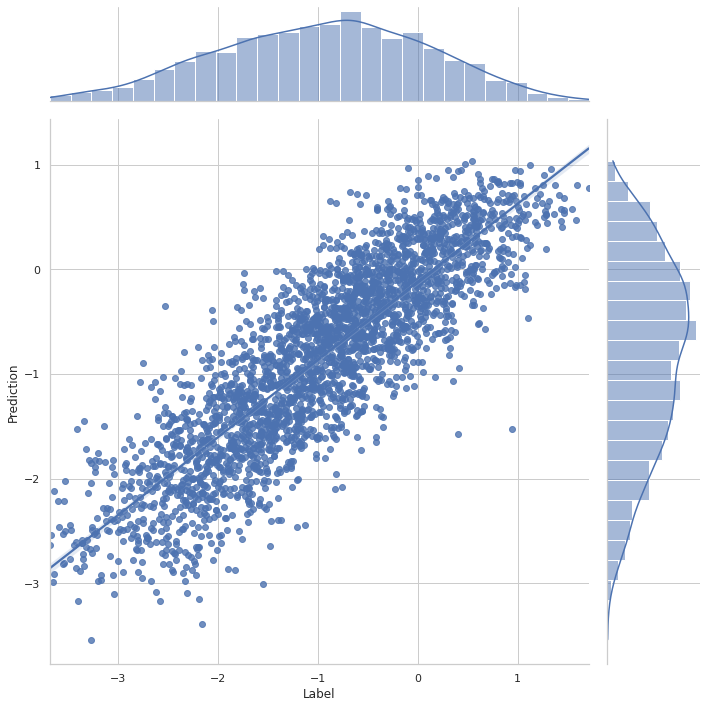

In [11]:
sns.jointplot(data=preds_df, x='Label', y='Prediction', kind='reg', height=10)
plt.show()